### Exploration to see what type of players cluster together, and to see if All Star Players are in the same clusters as well as what features tend to influence them to be in the same clusters.




In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE


In [76]:
from google.colab import drive 
drive.mount('/content/gdrive')
Seasons_Stats = pd.read_csv('gdrive/My Drive/Colab Notebooks/Seasons_Stats.csv')
All_NBA = pd.read_csv('gdrive/My Drive/Colab Notebooks/All.NBA.1984-2018.csv',skiprows=1)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Cleaning

In [77]:
#checking the data size
print(All_NBA.shape)
print(Seasons_Stats.shape)

(475, 33)
(24691, 53)


In [78]:
#convert the seasons to the numeric value
All_NBA['Year'] = pd.to_numeric(All_NBA['Season'].str[:4]) + 1
#Filter the seasons to period 1998 - 2007
All_NBA_PostMJ = All_NBA[All_NBA['Year'] > 1998] 
Seasons_Stats_PostMJ = Seasons_Stats[Seasons_Stats['Year'].between(1999, 2017)] 

In [79]:
#drop 3 useless columns
Seasons_Stats_PostMJ=Seasons_Stats_PostMJ.drop(['blanl','blank2','Unnamed: 0'], axis = 1)

In [80]:
#Remove the missing values for PER which is NULL
Seasons_Stats_PostMJ = Seasons_Stats_PostMJ[Seasons_Stats_PostMJ['PER'].notna()]

In [81]:
#Replace all other missing values with mean value
Seasons_Stats_PostMJ = Seasons_Stats_PostMJ.fillna(Seasons_Stats_PostMJ.mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [82]:
# Take out the duplicate of the players since the players may change teams
Seasons_Stats_PostMJ = Seasons_Stats_PostMJ[Seasons_Stats_PostMJ['Tm'] != "TOT"] 
Seasons_Stats_PostMJ['Tm']
All_NBA_PostMJ [All_NBA_PostMJ ['Tm'] == 'TOT']
All_NBA_PostMJ.loc[314,'Tm'] = 'DEN'
All_NBA_PostMJ.loc[412,'Tm'] = 'ATL'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [83]:
#Change some stats  to per game level
NBA_Stas_Per_Game = Seasons_Stats_PostMJ.assign(Minutes=lambda x: (x['MP'] / x['G']).round(2),
                                                   Points = lambda x: (x['PTS'] / x['G']).round(2),
                                                   Rebounds = lambda x: (x['TRB'] / x['G']).round(2),
                                                   Assists = lambda x: (x['AST'] / x['G']).round(2),
                                                   Steals = lambda x: (x['STL'] / x['G']).round(2),
                                                   Blocks = lambda x: (x['BLK'] / x['G']).round(2),
                                                   Turnovers = lambda x: (x['TOV'] / x['G']).round(2),
                                                   Fouls = lambda x: (x['PF'] / x['G']).round(2),
                                                   Free_Throws = lambda x: (x['FT'] / x['G']).round(2),
                                                   Three_Pointers = lambda x: (x['3P'] / x['G']).round(2),
                                                   Two_Pointers = lambda x: (x['2P'] / x['G']).round(2),
                                                   Field_Goals = lambda x: (x['FG'] / x['G']).round(2)

)

#Seasons_Stats_PostMJ[['MP','G','Minutes']] 
NBA_Stas_Per_Game[['PTS','G','Field_Goals']] 

,PTS,G,Field_Goals
13962,454.0,49.0,3.61
13963,1152.0,50.0,7.72
13964,261.0,36.0,2.69
13965,856.0,50.0,6.06
13966,2.0,2.0,0.50
...,...,...,...
24686,639.0,62.0,4.08
24687,178.0,51.0,1.53
24688,23.0,19.0,0.53
24689,240.0,44.0,2.00


In [84]:
# Drop some stats due to the duplication which may cause multicollinearity and also drop the columns that is not per game level
NBA_Stas_Per_Game=NBA_Stas_Per_Game.drop(['MP','FG','FGA','FG%','3P','3PA','2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PTS','PF','WS'], axis = 1)

In [85]:
# Rename some columns so that the data is easier to understand
dict = {
        'Player': 'Name',
        'Pos': 'Position',
        'Tm':'Team',
        'G' :'Games',
        'GS' :'Starts',
        'PER' : 'EfficiencyRating',
        '3PAr' : '3Points_Attemp_Rate',
        'FTr' : 'Free_Throw_Rate',
        'USG%' : 'Usage',
        'BPM' : 'BoxPlusMinus',
        'VORP' : 'ValueOverReplacement',
        'eFG%' : 'ShootingPercentage',
        'WS/48' : 'Win_Share_48mins'
          }
 
# call rename () method
NBA_Stas_Per_Game.rename(columns=dict,
          inplace=True)

In [86]:
#Reset the index
NBA_Stas_Per_Game=NBA_Stas_Per_Game.reset_index()

In [87]:
# Setting a minimum threshold (at least 10 games played, and for at least 5 minutes per game) 
NBA_Stas_Per_Game = NBA_Stas_Per_Game[(NBA_Stas_Per_Game.Games > 10)& (NBA_Stas_Per_Game.Minutes > 5)]
#Reset the index
NBA_Stas_Per_Game=NBA_Stas_Per_Game.reset_index()

In [88]:
NBA_Stas_Per_Game['ID']=NBA_Stas_Per_Game['Name'].str[:6]+ NBA_Stas_Per_Game['Age'].astype(str).str[:2] + NBA_Stas_Per_Game['Team'].str[:3]+ NBA_Stas_Per_Game['Year'].astype(str).str[2:4]
NBA_Stas_Per_Game[['ID','Year']]
All_NBA_PostMJ['ID']=All_NBA_PostMJ['Player'].str[:6]+ All_NBA_PostMJ['Age'].astype(str).str[:2] + All_NBA_PostMJ['Tm'].str[:3]+ All_NBA_PostMJ['Year'].astype(str).str[2:4]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
#merge two dataframe
All_NBA_IDs = All_NBA_PostMJ['ID'].to_frame()
All_NBA_IDs= All_NBA_IDs.assign(All_Star_Flag=1)


NBA_Combine = NBA_Stas_Per_Game.merge(All_NBA_IDs, on='ID', how='left')
NBA_Combine['All_Star_Flag'] = NBA_Combine['All_Star_Flag'].fillna(0)
NBA_Combine=NBA_Combine.drop(['level_0','index'],axis=1)

In [90]:
NBA_Combine

,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Steals,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag
0,1999.0,Tariq Abdul-Wahad,SG,24.0,SAC,49.0,49.0,11.8,0.486,0.052,...,1.02,0.33,1.43,2.47,1.92,0.12,3.49,3.61,Tariq 24SAC99,0.0
1,1999.0,Shareef Abdur-Rahim,SF,22.0,VAN,50.0,50.0,20.7,0.530,0.040,...,1.38,1.10,3.72,2.74,7.38,0.22,7.50,7.72,Sharee22VAN99,0.0
2,1999.0,Cory Alexander,PG,25.0,DEN,36.0,4.0,11.0,0.467,0.404,...,0.97,0.14,1.92,2.14,1.03,0.83,1.86,2.69,Cory A25DEN99,0.0
3,1999.0,Ray Allen,SG,23.0,MIL,50.0,50.0,18.9,0.564,0.309,...,1.06,0.14,2.44,2.34,3.52,1.48,4.58,6.06,Ray Al23MIL99,0.0
4,1999.0,Derek Anderson,SG,24.0,CLE,38.0,13.0,16.5,0.529,0.220,...,1.26,0.11,2.16,1.92,3.63,0.55,2.74,3.29,Derek 24CLE99,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8358,2017.0,Cody Zeller,PF,24.0,CHO,62.0,58.0,16.7,0.604,0.002,...,1.00,0.94,1.05,3.05,2.15,0.00,4.08,4.08,Cody Z24CHO17,0.0
8359,2017.0,Tyler Zeller,C,27.0,BOS,51.0,5.0,13.0,0.508,0.006,...,0.14,0.41,0.39,1.20,0.43,0.00,1.53,1.53,Tyler 27BOS17,0.0
8360,2017.0,Stephen Zimmerman,C,20.0,ORL,19.0,0.0,7.3,0.346,0.000,...,0.11,0.26,0.16,0.89,0.16,0.00,0.53,0.53,Stephe20ORL17,0.0
8361,2017.0,Paul Zipser,SF,22.0,CHI,44.0,18.0,6.9,0.503,0.448,...,0.34,0.36,0.91,1.77,0.70,0.75,1.25,2.00,Paul Z22CHI17,0.0


# Principle Component Analysis

In [91]:
NBA_Combine.describe()

,Year,Age,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,Free_Throw_Rate,ORB%,DRB%,...,Assists,Steals,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,All_Star_Flag
count,8363.000000,8363.000000,8363.000000,8363.000000,8363.000000,8363.000000,8363.000000,8363.000000,8363.000000,8363.000000,...,8363.000000,8363.000000,8363.000000,8363.000000,8363.000000,8363.000000,8363.000000,8363.000000,8363.000000,8363.000000
mean,2008.270358,26.979433,53.869784,26.755112,13.309327,0.515532,0.213202,0.299086,5.699031,14.461377,...,1.931697,0.690200,0.441985,1.265943,1.977869,1.618251,0.568668,2.696280,3.265014,0.034198
std,5.441803,4.343101,22.177636,28.619995,4.531763,0.061128,0.198712,0.158938,3.986439,5.650069,...,1.820614,0.434531,0.491208,0.770962,0.740473,1.409739,0.653289,1.896182,2.101170,0.181749
min,1999.000000,18.000000,11.000000,0.000000,-6.800000,0.113000,0.000000,0.000000,0.000000,2.200000,...,0.000000,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000,0.070000,0.000000
25%,2004.000000,24.000000,34.500000,2.000000,10.400000,0.483000,0.011000,0.191000,2.300000,9.900000,...,0.660000,0.360000,0.130000,0.680000,1.430000,0.630000,0.000000,1.230000,1.610000,0.000000
50%,2008.000000,26.000000,57.000000,14.000000,13.100000,0.521000,0.190000,0.272000,4.500000,13.500000,...,1.330000,0.610000,0.280000,1.090000,1.960000,1.180000,0.320000,2.190000,2.780000,0.000000
75%,2013.000000,30.000000,75.000000,50.000000,16.000000,0.554000,0.365500,0.374000,8.700000,18.300000,...,2.570000,0.925000,0.560000,1.690000,2.500000,2.150000,0.970000,3.720000,4.500000,0.000000
max,2017.000000,42.000000,82.000000,82.000000,31.700000,0.762000,0.915000,1.538000,26.300000,38.000000,...,12.750000,3.000000,4.410000,5.730000,4.520000,10.270000,5.090000,12.100000,12.220000,1.000000


In [92]:
drop = ['Age','Position','Team','Name','ID','All_Star_Flag']
df_train = NBA_Combine.drop(columns=drop)
df_train.head()

,Year,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,Free_Throw_Rate,ORB%,DRB%,TRB%,...,Rebounds,Assists,Steals,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals
0,1999.0,49.0,49.0,11.8,0.486,0.052,0.334,6.3,9.9,8.1,...,3.80,1.02,1.02,0.33,1.43,2.47,1.92,0.12,3.49,3.61
1,1999.0,50.0,50.0,20.7,0.530,0.040,0.492,6.5,15.4,10.9,...,7.48,3.44,1.38,1.10,3.72,2.74,7.38,0.22,7.50,7.72
2,1999.0,36.0,4.0,11.0,0.467,0.404,0.169,1.0,10.3,5.5,...,2.06,3.31,0.97,0.14,1.92,2.14,1.03,0.83,1.86,2.69
3,1999.0,50.0,50.0,18.9,0.564,0.309,0.290,4.1,10.7,7.4,...,4.24,3.56,1.06,0.14,2.44,2.34,3.52,1.48,4.58,6.06
4,1999.0,38.0,13.0,16.5,0.529,0.220,0.525,2.6,11.5,7.1,...,2.87,3.82,1.26,0.11,2.16,1.92,3.63,0.55,2.74,3.29


In [93]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_train))
df_scaled.columns = df_train.columns

In [94]:
# Apply PCA
n_components=df_train.shape[1]
pca = PCA(n_components=n_components, random_state=123)
pca.fit(df_scaled)

PCA(n_components=38, random_state=123)

In [95]:
explained_variance_ratio = pca.explained_variance_ratio_ 
cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
var = []
for i in range (0, n_components):
    var.append([i+1, round(explained_variance_ratio[i],6), cum_explained_variance_ratio[i]])

pca_predictor = pd.DataFrame(var)
pca_predictor.columns = ['Component', 'Explained Variance', 'Cumulative Explained Variance']
pca_predictor

,Component,Explained Variance,Cumulative Explained Variance
0,1,0.390795,0.390795
1,2,0.172295,0.563090
2,3,0.098627,0.661718
3,4,0.073551,0.735268
4,5,0.042187,0.777455
5,6,0.036199,0.813654
6,7,0.032766,0.846420
7,8,0.022827,0.869247
8,9,0.017745,0.886993
9,10,0.016356,0.903349



Bar chart is used to represent individual explained variances.
Step plot is used to represent the variance explained by different principal components.

Eigenvalues start to form a straight line after the tenth principal component. 

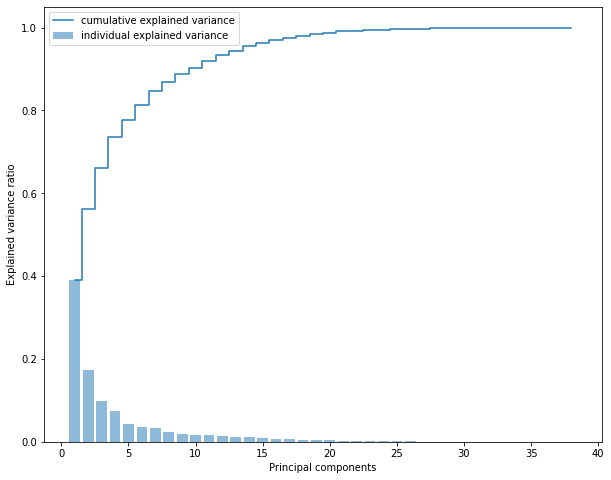

In [96]:
plt.subplots(figsize=(10,8))

plt.bar(pca_predictor['Component'],pca_predictor['Explained Variance'], align='center', alpha=0.5, 
       label='individual explained variance')
plt.step(pca_predictor['Component'],pca_predictor['Cumulative Explained Variance'], where='mid',
         label='cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio');
plt.legend(loc='best')

In [97]:
# 10 components based on graph above
pca = PCA(n_components=10)
pca.fit(df_scaled)

PCA(n_components=10)

In [98]:
transformed = pca.fit_transform(df_scaled)
transformed.shape

(8363, 10)

# Kmeans

Elbow Method to Decide how many clusters to use.

In [99]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(transformed)
    kmeanModel.fit(transformed)
  
    distortions.append(sum(np.min(cdist(transformed, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / transformed.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(transformed, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / transformed.shape[0]
    mapping2[k] = kmeanModel.inertia_


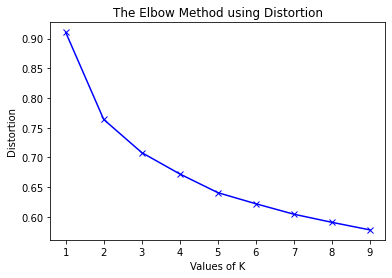

In [100]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

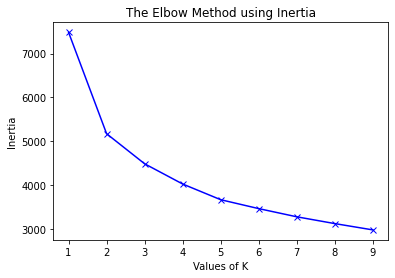

In [101]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [102]:
# Deciding on 5 clusters because it starts to linearly descend at 5.

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(transformed)

KMeans(n_clusters=5, random_state=0)

In [103]:
cluster_labels = kmeans.labels_
NBA_Combine['cluster'] = cluster_labels

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


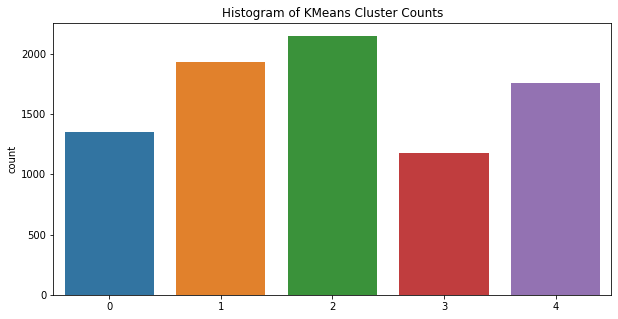

In [104]:
ax=plt.subplots(figsize=(10,5))
ax=sns.countplot(cluster_labels)
title="Histogram of KMeans Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [105]:
def cluster_stats(columns, nba_df):
    output = pd.DataFrame({'cluster':[ i for i in range(n_clusters)]})
    for column in columns:
        lst = []
        for i in range(n_clusters):
            mean = nba_df[nba_df['cluster'] == i].describe()[column]['mean']
            lst.append([i, round(mean,2)])
        df = pd.DataFrame(lst)
        df.columns = ['cluster', column]
        output = pd.merge(output, df, on='cluster', how='outer')
    return output

columns = df_train.columns
cluster_stats(columns, NBA_Combine)

,cluster,Year,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,Free_Throw_Rate,ORB%,DRB%,...,Rebounds,Assists,Steals,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals
0,0,2008.01,70.13,66.92,17.38,0.54,0.28,0.30,3.07,11.85,...,4.52,4.58,1.26,0.37,2.29,2.33,3.35,1.32,4.76,6.08
1,1,2007.38,44.55,8.46,12.38,0.51,0.03,0.39,10.13,18.55,...,3.71,0.59,0.40,0.55,0.78,1.97,0.93,0.03,1.84,1.86
2,2,2009.13,62.19,20.10,12.75,0.53,0.35,0.24,3.17,11.44,...,2.97,2.19,0.76,0.25,1.25,1.93,1.43,0.94,2.32,3.26
3,3,2007.85,68.59,58.70,17.19,0.54,0.04,0.37,9.52,21.23,...,8.04,1.72,0.79,1.17,1.74,2.84,2.59,0.15,4.84,4.98
4,4,2008.68,31.64,2.78,9.30,0.47,0.32,0.23,3.40,11.16,...,1.58,1.20,0.41,0.13,0.72,1.20,0.62,0.41,1.09,1.50


In [106]:
# Create dataframe of only All Star Players
all_stars = NBA_Combine[NBA_Combine['All_Star_Flag']==1]

In [107]:
# Check what clusters all starts are in
all_stars.groupby('cluster').count()

,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Steals,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag
cluster,,,,,,,,,,,,,,,,,,,,,
0,176,176,176,176,176,176,176,176,176,176,...,176,176,176,176,176,176,176,176,176,176
3,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [108]:
NBA_Combine[NBA_Combine['cluster']==0]

,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag,cluster
1,1999.0,Shareef Abdur-Rahim,SF,22.0,VAN,50.0,50.0,20.7,0.530,0.040,...,1.10,3.72,2.74,7.38,0.22,7.50,7.72,Sharee22VAN99,0.0,0
3,1999.0,Ray Allen,SG,23.0,MIL,50.0,50.0,18.9,0.564,0.309,...,0.14,2.44,2.34,3.52,1.48,4.58,6.06,Ray Al23MIL99,0.0,0
6,1999.0,Nick Anderson,SF,31.0,ORL,47.0,39.0,15.3,0.493,0.433,...,0.32,1.77,1.53,2.11,2.04,3.34,5.38,Nick A31ORL99,0.0,0
11,1999.0,Darrell Armstrong,PG,30.0,ORL,50.0,15.0,22.2,0.575,0.362,...,0.08,3.16,1.80,3.22,1.38,3.22,4.60,Darrel30ORL99,0.0,0
27,1999.0,Mike Bibby,PG,20.0,VAN,50.0,50.0,14.8,0.487,0.122,...,0.10,2.92,2.44,2.54,0.30,4.90,5.20,Mike B20VAN99,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8328,2017.0,Kemba Walker,PG,26.0,CHO,79.0,79.0,21.3,0.569,0.415,...,0.28,2.13,1.51,3.85,3.04,5.10,8.14,Kemba 26CHO17,0.0,0
8329,2017.0,John Wall,PG,26.0,WAS,78.0,78.0,23.2,0.541,0.190,...,0.63,4.14,1.94,5.41,1.14,7.15,8.29,John W26WAS17,1.0,0
8335,2017.0,Russell Westbrook,PG,28.0,OKC,81.0,81.0,30.6,0.554,0.300,...,0.38,5.41,2.35,8.77,2.47,7.70,10.17,Russel28OKC17,1.0,0
8339,2017.0,Andrew Wiggins,SF,21.0,MIN,82.0,82.0,16.5,0.534,0.184,...,0.37,2.28,2.23,5.02,1.26,7.39,8.65,Andrew21MIN17,0.0,0


Based on the Feature Importance explored using the Random Forest Algorithm, these were the top 5 features:

In [109]:
kmeans_stats = cluster_stats(columns, NBA_Combine)

In [110]:
top_features = kmeans_stats[['cluster','EfficiencyRating','ValueOverReplacement','Points','Field_Goals','Two_Pointers']].copy()
top_features

,cluster,EfficiencyRating,ValueOverReplacement,Points,Field_Goals,Two_Pointers
0,0,17.38,2.35,16.81,6.08,4.76
1,1,12.38,0.03,4.69,1.86,1.84
2,2,12.75,0.33,8.90,3.26,2.32
3,3,17.19,1.64,12.71,4.98,4.84
4,4,9.30,-0.19,4.03,1.50,1.09


Clusters 0 and 3 (the clusters with all star players in them) have the highest values in the top most important features

# Gaussian

In [111]:
NBA_Gaussian = NBA_Combine.copy()
gmm = GaussianMixture(n_components=5, random_state=0)
gmm.fit(transformed)

#predictions from gmm
labels = gmm.predict(transformed)
NBA_Gaussian['cluster'] = labels

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


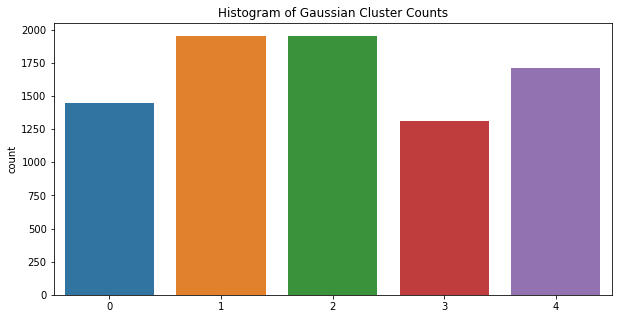

In [112]:
ax=plt.subplots(figsize=(10,5))
ax=sns.countplot(labels)
title="Histogram of Gaussian Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [113]:
columns = df_train.columns
cluster_stats_df = cluster_stats(columns, NBA_Gaussian)

In [114]:
cluster_stats_df

,cluster,Year,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,Free_Throw_Rate,ORB%,DRB%,...,Rebounds,Assists,Steals,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals
0,0,2008.31,67.01,66.15,16.99,0.54,0.28,0.29,3.30,12.43,...,4.75,4.31,1.23,0.41,2.22,2.34,3.22,1.29,4.69,5.97
1,1,2008.85,40.88,1.78,10.15,0.48,0.34,0.22,3.50,11.52,...,1.75,1.21,0.45,0.15,0.72,1.26,0.66,0.48,1.15,1.63
2,2,2008.73,59.40,23.58,12.85,0.52,0.33,0.24,3.15,11.38,...,3.06,2.39,0.80,0.24,1.35,1.98,1.56,0.94,2.48,3.42
3,3,2007.72,61.84,52.44,16.20,0.54,0.03,0.37,9.67,20.84,...,7.50,1.54,0.73,1.12,1.61,2.79,2.28,0.07,4.37,4.44
4,4,2007.47,45.16,5.89,12.12,0.51,0.02,0.40,10.11,18.18,...,3.41,0.53,0.36,0.51,0.73,1.87,0.92,0.01,1.75,1.76


In [115]:
all_stars_gaus = NBA_Gaussian[NBA_Gaussian['All_Star_Flag']==1]
all_stars_gaus.groupby('cluster').count()

,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Steals,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag
cluster,,,,,,,,,,,,,,,,,,,,,
0,183,183,183,183,183,183,183,183,183,183,...,183,183,183,183,183,183,183,183,183,183
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101


In [116]:
NBA_Gaussian[NBA_Gaussian['cluster']==0]


,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag,cluster
1,1999.0,Shareef Abdur-Rahim,SF,22.0,VAN,50.0,50.0,20.7,0.530,0.040,...,1.10,3.72,2.74,7.38,0.22,7.50,7.72,Sharee22VAN99,0.0,0
3,1999.0,Ray Allen,SG,23.0,MIL,50.0,50.0,18.9,0.564,0.309,...,0.14,2.44,2.34,3.52,1.48,4.58,6.06,Ray Al23MIL99,0.0,0
27,1999.0,Mike Bibby,PG,20.0,VAN,50.0,50.0,14.8,0.487,0.122,...,0.10,2.92,2.44,2.54,0.30,4.90,5.20,Mike B20VAN99,0.0,0
29,1999.0,Mookie Blaylock,PG,31.0,ATL,48.0,48.0,16.7,0.463,0.386,...,0.19,2.40,1.27,1.44,1.60,3.54,5.15,Mookie31ATL99,0.0,0
38,1999.0,Terrell Brandon,PG,28.0,MIN,21.0,20.0,20.9,0.466,0.064,...,0.33,1.81,2.71,1.86,0.24,5.81,6.05,Terrel28MIN99,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8341,2017.0,Deron Williams,PG,32.0,DAL,40.0,40.0,15.0,0.533,0.400,...,0.05,2.45,2.40,1.72,1.58,3.30,4.88,Deron 32DAL17,0.0,0
8347,2017.0,Marvin Williams,PF,30.0,CHO,76.0,76.0,13.7,0.551,0.503,...,0.70,0.79,1.76,1.72,1.63,2.28,3.91,Marvin30CHO17,0.0,0
8349,2017.0,Justise Winslow,SF,20.0,MIA,18.0,15.0,8.2,0.399,0.156,...,0.33,1.83,2.89,1.61,0.39,4.06,4.44,Justis20MIA17,0.0,0
8356,2017.0,Nick Young,SG,31.0,LAL,60.0,60.0,14.1,0.588,0.665,...,0.23,0.60,2.28,1.28,2.83,1.70,4.53,Nick Y31LAL17,0.0,0


In [117]:
gaus_stats = cluster_stats(columns, NBA_Gaussian)

In [118]:
top_features = gaus_stats[['cluster','EfficiencyRating','ValueOverReplacement','Points','Field_Goals','Two_Pointers']].copy()
top_features

,cluster,EfficiencyRating,ValueOverReplacement,Points,Field_Goals,Two_Pointers
0,0,16.99,2.21,16.46,5.97,4.69
1,1,10.15,-0.07,4.39,1.63,1.15
2,2,12.85,0.38,9.35,3.42,2.48
3,3,16.20,1.28,11.24,4.44,4.37
4,4,12.12,0.04,4.45,1.76,1.75


Clusters 0 and 3 (the clusters with all star players in them) have the highest values in the top most important features

# TSNE

In [120]:
kmeans = KMeans(n_clusters=5, random_state=0)
skillsPCA_labels = kmeans.fit_predict(transformed)

dfskillsPCA = pd.DataFrame(transformed)
dfskillsPCA['cluster'] = skillsPCA_labels

X = dfskillsPCA.iloc[:,:-1]
Xtsne = TSNE(n_components=10, method='exact').fit_transform(X)
dftsne = pd.DataFrame(Xtsne)
dftsne['cluster'] = skillsPCA_labels

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [121]:
NBA_tsne = NBA_Combine.copy()
NBA_tsne['cluster'] = skillsPCA_labels

In [122]:
columns = df_train.columns
cluster_stats_df = cluster_stats(columns, NBA_tsne)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


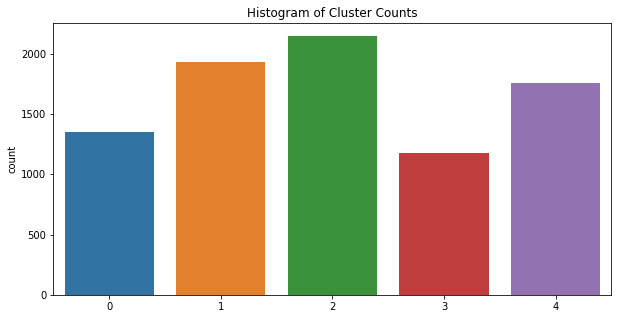

In [123]:
ax=plt.subplots(figsize=(10,5))
ax=sns.countplot(skillsPCA_labels)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [124]:
all_stars_tsne = NBA_tsne[NBA_tsne['All_Star_Flag']==1]
all_stars_tsne.groupby('cluster').count()

,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Steals,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag
cluster,,,,,,,,,,,,,,,,,,,,,
0,176,176,176,176,176,176,176,176,176,176,...,176,176,176,176,176,176,176,176,176,176
3,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [125]:
tsne_stats = cluster_stats(columns, NBA_tsne)
top_features = tsne_stats[['cluster','EfficiencyRating','ValueOverReplacement','Points','Field_Goals','Two_Pointers']].copy()
top_features

,cluster,EfficiencyRating,ValueOverReplacement,Points,Field_Goals,Two_Pointers
0,0,17.38,2.35,16.81,6.08,4.76
1,1,12.38,0.03,4.69,1.86,1.84
2,2,12.75,0.33,8.90,3.26,2.32
3,3,17.19,1.64,12.71,4.98,4.84
4,4,9.30,-0.19,4.03,1.50,1.09


# Final Analysis: 
Kmeans (PCA) seems to be the best clustering method based on the big differneces in clusters stats between all star clusters and non all star clusters. Now using the kmeans clustering we can see what clusters Stephen Curry, LeBron James, Kobe Bryant and Russell Westbrook (all star atheletes) fall in and see if other players that became all stars later in their lives like Devin Booker, Anthony Davis and Draymond Green.

In [156]:
# Pretty much always in cluster 0
steph = NBA_Combine[NBA_Combine['Name']=='Stephen Curry']
steph

,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag,cluster
4776,2010.0,Stephen Curry,PG,21.0,GSW,80.0,77.0,16.3,0.568,0.332,...,0.24,3.04,3.15,2.21,2.08,4.53,6.60,Stephe21GSW10,0.0,0
5226,2011.0,Stephen Curry,PG,22.0,GSW,74.0,74.0,19.4,0.595,0.325,...,0.27,3.05,3.15,2.86,2.04,4.78,6.82,Stephe22GSW11,0.0,0
5677,2012.0,Stephen Curry,PG,23.0,GSW,26.0,23.0,21.2,0.605,0.409,...,0.31,2.50,2.38,1.46,2.12,3.46,5.58,Stephe23GSW12,0.0,2
6129,2013.0,Stephen Curry,PG,24.0,GSW,78.0,78.0,21.3,0.589,0.432,...,0.15,3.08,2.54,3.36,3.49,4.54,8.03,Stephe24GSW13,0.0,0
6597,2014.0,Stephen Curry,PG,25.0,GSW,78.0,78.0,24.1,0.610,0.445,...,0.18,3.77,2.49,3.95,3.35,5.01,8.36,Stephe25GSW14,1.0,0
7059,2015.0,Stephen Curry,PG,26.0,GSW,80.0,80.0,28.0,0.638,0.482,...,0.20,3.11,1.98,3.85,3.58,4.59,8.16,Stephe26GSW15,1.0,0
7534,2016.0,Stephen Curry,PG,27.0,GSW,79.0,79.0,31.5,0.669,0.554,...,0.19,3.32,2.04,4.59,5.09,5.10,10.19,Stephe27GSW16,1.0,0
7997,2017.0,Stephen Curry,PG,28.0,GSW,79.0,79.0,24.6,0.624,0.547,...,0.22,3.03,2.32,4.11,4.10,4.44,8.54,Stephe28GSW17,1.0,0


In [157]:
# Always was in cluster 0
lebron = NBA_Combine[NBA_Combine['Name']=='LeBron James']
lebron

,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag,cluster
2219,2004.0,LeBron James,SG,19.0,CLE,79.0,79.0,18.3,0.488,0.145,...,0.73,3.46,1.89,4.39,0.80,7.08,7.87,LeBron19CLE04,0.0,0
2665,2005.0,LeBron James,SF,20.0,CLE,80.0,80.0,25.7,0.554,0.183,...,0.65,3.28,1.82,5.96,1.35,8.59,9.94,LeBron20CLE05,1.0,0
3117,2006.0,LeBron James,SF,21.0,CLE,79.0,79.0,28.1,0.568,0.208,...,0.84,3.29,2.29,7.61,1.61,9.47,11.08,LeBron21CLE06,1.0,0
3568,2007.0,LeBron James,SF,22.0,CLE,78.0,78.0,24.5,0.552,0.191,...,0.71,3.21,2.19,6.27,1.27,8.63,9.90,LeBron22CLE07,1.0,0
4015,2008.0,LeBron James,SF,23.0,CLE,75.0,74.0,29.1,0.568,0.219,...,1.08,3.40,2.20,7.32,1.51,9.08,10.59,LeBron23CLE08,1.0,0
4451,2009.0,LeBron James,SF,24.0,CLE,81.0,81.0,31.7,0.591,0.238,...,1.15,2.98,1.72,7.33,1.63,8.11,9.74,LeBron24CLE09,1.0,0
4892,2010.0,LeBron James,SF,25.0,CLE,76.0,76.0,31.1,0.604,0.253,...,1.01,3.43,1.57,7.80,1.70,8.41,10.11,LeBron25CLE10,1.0,0
5357,2011.0,LeBron James,SF,26.0,MIA,79.0,79.0,27.3,0.594,0.188,...,0.63,3.59,2.06,6.37,1.16,8.43,9.59,LeBron26MIA11,1.0,0
5800,2012.0,LeBron James,SF,27.0,MIA,62.0,62.0,30.7,0.605,0.127,...,0.81,3.44,1.55,6.24,0.87,9.15,10.02,LeBron27MIA12,1.0,0
6239,2013.0,LeBron James,PF,28.0,MIA,76.0,76.0,31.6,0.640,0.188,...,0.88,2.97,1.45,5.30,1.36,8.71,10.07,LeBron28MIA13,1.0,0


In [158]:
# Always was in cluster 0
kobe = NBA_Combine[NBA_Combine['Name']=='Kobe Bryant']
kobe

,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag,cluster
45,1999.0,Kobe Bryant,SG,20.0,LAL,50.0,50.0,18.9,0.549,0.130,...,1.00,3.14,3.06,4.90,0.54,6.70,7.24,Kobe B20LAL99,1.0,0
432,2000.0,Kobe Bryant,SG,21.0,LAL,66.0,62.0,21.7,0.546,0.122,...,0.94,2.76,3.33,5.02,0.70,7.70,8.39,Kobe B21LAL00,1.0,0
832,2001.0,Kobe Bryant,SG,22.0,LAL,68.0,68.0,24.5,0.552,0.132,...,0.63,3.24,3.26,6.99,0.90,9.41,10.31,Kobe B22LAL01,1.0,0
1262,2002.0,Kobe Bryant,SG,23.0,LAL,80.0,80.0,23.2,0.544,0.083,...,0.44,2.79,2.85,6.10,0.41,8.95,9.36,Kobe B23LAL02,1.0,0
1672,2003.0,Kobe Bryant,SG,24.0,LAL,82.0,82.0,26.2,0.550,0.168,...,0.82,3.51,2.66,7.33,1.51,9.07,10.59,Kobe B24LAL03,1.0,0
2088,2004.0,Kobe Bryant,SG,25.0,LAL,65.0,64.0,23.7,0.551,0.184,...,0.43,2.63,2.71,6.98,1.09,6.85,7.94,Kobe B25LAL04,1.0,0
2521,2005.0,Kobe Bryant,SG,26.0,LAL,66.0,66.0,23.3,0.563,0.292,...,0.80,4.09,2.64,8.21,1.98,6.70,8.68,Kobe B26LAL05,1.0,0
2978,2006.0,Kobe Bryant,SG,27.0,LAL,80.0,80.0,28.0,0.559,0.238,...,0.38,3.12,2.91,8.70,2.25,9.98,12.22,Kobe B27LAL06,1.0,0
3428,2007.0,Kobe Bryant,SG,28.0,LAL,77.0,77.0,26.1,0.580,0.227,...,0.47,3.31,2.66,8.66,1.78,8.78,10.56,Kobe B28LAL07,1.0,0
3866,2008.0,Kobe Bryant,SG,29.0,LAL,82.0,82.0,24.2,0.576,0.246,...,0.49,3.13,2.77,7.60,1.83,7.62,9.45,Kobe B29LAL08,1.0,0


In [159]:
# Always was in cluster 0
russ = NBA_Combine[NBA_Combine['Name']=='Russell Westbrook']
russ

,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag,cluster
4666,2009.0,Russell Westbrook,PG,20.0,OKC,82.0,65.0,15.2,0.489,0.118,...,0.20,3.34,2.33,4.26,0.43,4.89,5.32,Russel20OKC09,0.0,0
5095,2010.0,Russell Westbrook,PG,21.0,OKC,82.0,82.0,17.8,0.491,0.090,...,0.41,3.27,2.49,4.01,0.28,5.63,5.91,Russel21OKC10,0.0,0
5557,2011.0,Russell Westbrook,PG,22.0,OKC,82.0,82.0,23.6,0.538,0.074,...,0.37,3.85,2.52,6.48,0.41,7.07,7.49,Russel22OKC11,1.0,0
6006,2012.0,Russell Westbrook,PG,23.0,OKC,66.0,66.0,22.9,0.538,0.155,...,0.32,3.62,2.23,5.15,0.94,7.82,8.76,Russel23OKC12,1.0,0
6467,2013.0,Russell Westbrook,PG,24.0,OKC,82.0,82.0,23.9,0.532,0.195,...,0.29,3.33,2.30,5.61,1.18,7.02,8.21,Russel24OKC13,1.0,0
6932,2014.0,Russell Westbrook,PG,25.0,OKC,46.0,46.0,24.7,0.545,0.271,...,0.15,3.85,2.26,5.26,1.48,6.04,7.52,Russel25OKC14,0.0,0
7414,2015.0,Russell Westbrook,PG,26.0,OKC,67.0,67.0,29.1,0.536,0.196,...,0.21,4.37,2.75,8.15,1.28,8.07,9.36,Russel26OKC15,1.0,0
7879,2016.0,Russell Westbrook,PG,27.0,OKC,80.0,80.0,27.6,0.554,0.236,...,0.25,4.28,2.50,5.81,1.26,6.94,8.20,Russel27OKC16,1.0,0
8335,2017.0,Russell Westbrook,PG,28.0,OKC,81.0,81.0,30.6,0.554,0.300,...,0.38,5.41,2.35,8.77,2.47,7.70,10.17,Russel28OKC17,1.0,0


In [160]:
# Made his way to cluster 0
devin = NBA_Combine[NBA_Combine['Name']=='Devin Booker']
devin 

,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag,cluster
7490,2016.0,Devin Booker,SG,19.0,PHO,76.0,51.0,11.9,0.535,0.333,...,0.26,2.11,2.96,2.83,1.30,3.53,4.83,Devin 19PHO16,0.0,2
7952,2017.0,Devin Booker,SG,20.0,PHO,78.0,78.0,14.6,0.531,0.283,...,0.27,3.09,3.10,4.71,1.88,5.88,7.77,Devin 20PHO17,0.0,0


In [161]:
# Mainly in cluster 3 (the second highest cluster)
anth = NBA_Combine[NBA_Combine['Name']=='Anthony Davis']
anth

,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag,cluster
6132,2013.0,Anthony Davis,PF,19.0,NOH,64.0,60.0,21.7,0.559,0.009,...,1.75,1.39,2.47,2.64,0.00,5.45,5.45,Anthon19NOH13,0.0,3
6601,2014.0,Anthony Davis,PF,20.0,NOP,67.0,66.0,26.5,0.582,0.009,...,2.82,1.63,2.99,5.19,0.03,7.76,7.79,Anthon20NOP14,0.0,3
7066,2015.0,Anthony Davis,PF,21.0,NOP,68.0,68.0,30.8,0.591,0.010,...,2.94,1.40,2.07,5.46,0.01,9.43,9.44,Anthon21NOP15,1.0,3
7536,2016.0,Anthony Davis,C,22.0,NOP,61.0,61.0,25.0,0.559,0.095,...,2.05,1.98,2.43,5.34,0.57,8.61,9.18,Anthon22NOP16,0.0,3
7999,2017.0,Anthony Davis,C,23.0,NOP,75.0,75.0,27.5,0.579,0.088,...,2.23,2.41,2.24,6.92,0.53,9.73,10.27,Anthon23NOP17,1.0,3


In [162]:
# Made his way into cluster 0, but was in cluster 3 at one point as well
dray = NBA_Combine[NBA_Combine['Name']=='Draymond Green']
dray

,Year,Name,Position,Age,Team,Games,Starts,EfficiencyRating,TS%,3Points_Attemp_Rate,...,Blocks,Turnovers,Fouls,Free_Throws,Three_Pointers,Two_Pointers,Field_Goals,ID,All_Star_Flag,cluster
6192,2013.0,Draymond Green,SF,22.0,GSW,79.0,1.0,7.1,0.404,0.261,...,0.32,0.65,2.01,0.57,0.18,0.89,1.06,Draymo22GSW13,0.0,1
6665,2014.0,Draymond Green,SF,23.0,GSW,82.0,12.0,12.7,0.498,0.359,...,0.88,1.11,2.82,1.00,0.67,1.61,2.28,Draymo23GSW14,0.0,2
7129,2015.0,Draymond Green,PF,24.0,GSW,79.0,79.0,16.4,0.540,0.430,...,1.25,1.68,3.20,1.67,1.41,2.89,4.29,Draymo24GSW15,0.0,3
7592,2016.0,Draymond Green,PF,25.0,GSW,81.0,81.0,19.3,0.587,0.315,...,1.40,3.20,2.96,2.83,1.23,3.72,4.95,Draymo25GSW16,1.0,0
8063,2017.0,Draymond Green,PF,26.0,GSW,76.0,76.0,16.5,0.522,0.405,...,1.39,2.42,2.86,1.99,1.07,2.51,3.58,Draymo26GSW17,1.0,0


In [167]:
# Create df of players and create a column of order of importance of cluster

def importance_level(num):
    if num == 0:
        val = 1
    elif num == 3:
        val = 2
    elif num == 1:
        val = 3
    elif num == 2:
        val = 4
    else:
        val = 5
    return val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

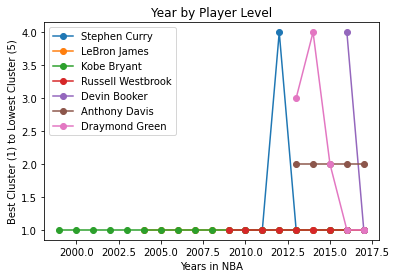

In [173]:
steph = NBA_Combine[NBA_Combine['Name']=='Stephen Curry']
lebron = NBA_Combine[NBA_Combine['Name']=='LeBron James']
kobe = NBA_Combine[NBA_Combine['Name']=='Kobe Bryant']
russ = NBA_Combine[NBA_Combine['Name']=='Russell Westbrook']
devin = NBA_Combine[NBA_Combine['Name']=='Devin Booker']
anth = NBA_Combine[NBA_Combine['Name']=='Anthony Davis']
dray = NBA_Combine[NBA_Combine['Name']=='Draymond Green']
# X-axis values
x = steph['Year'].to_list()
x1 = lebron['Year'].to_list()
x2 = kobe['Year'].to_list()
x3 = russ['Year'].to_list()
x4 = devin['Year'].to_list()
x5 = anth['Year'].to_list()
x6 = dray['Year'].to_list()


# Y-axis values
steph['Importance_Level'] = steph['cluster'].apply(importance_level)
y = steph['Importance_Level'].to_list()
lebron['Importance_Level'] = lebron['cluster'].apply(importance_level)
y1 = lebron['Importance_Level'].to_list()
kobe['Importance_Level'] = kobe['cluster'].apply(importance_level)
y2 = kobe['Importance_Level'].to_list()
russ['Importance_Level'] = russ['cluster'].apply(importance_level)
y3 = russ['Importance_Level'].to_list()
devin['Importance_Level'] = devin['cluster'].apply(importance_level)
y4 = devin['Importance_Level'].to_list()
anth['Importance_Level'] = anth['cluster'].apply(importance_level)
y5 = anth['Importance_Level'].to_list()
dray['Importance_Level'] = dray['cluster'].apply(importance_level)
y6 = dray['Importance_Level'].to_list()
  
# Function to plot  
plt.plot(x, y, marker='o', label ='Stephen Curry')
plt.plot(x1, y1, marker='o', label ='LeBron James')
plt.plot(x2, y2, marker='o', label ='Kobe Bryant')
plt.plot(x3, y3, marker='o', label ='Russell Westbrook')
plt.plot(x4, y4, marker='o', label ='Devin Booker')
plt.plot(x5, y5, marker='o', label ='Anthony Davis')
plt.plot(x6, y6, marker='o', label ='Draymond Green')

plt.title('Year by Player Level')
plt.xlabel("Years in NBA")
plt.ylabel("Best Cluster (1) to Lowest Cluster (5)")

  
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

Final Thoughts:

It is interesting to see how certain players were always in cluster 0 (the top cluster) and how other players made their way into cluster 0 throughout the years. Some All star players were in cluster 3 (the second highest cluster).